# RNetwork Visualization - Walker

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from omegaconf import OmegaConf

import envs
import utils
import envs.walker_utils as walker_utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.utils import load
from exploration_buffer import ExplorationBuffer

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Config Utils

In [5]:
cfg_path = f"../conf/config.yaml"

env_name = 'walker'

cfg = OmegaConf.load(cfg_path)
env_cfg = OmegaConf.load(f'../conf/env/{env_name}.yaml')
env_cfg.action_repeat=1
cfg = OmegaConf.merge(cfg, env_cfg)

cfg.rnet.model.remove_velocity=True

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
device = torch.device("cpu")

In [6]:
env = envs.make_env(cfg.env, space_info)
expl_buffer = ExplorationBuffer(cfg.exploration_buffer)

/private/home/linamezghani/.conda/envs/polybeast/lib/python3.7/site-packages/omegaconf/resolvers/__init__.py:13: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  "The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573"


In [7]:
env.goals['vec_obs'].dtype

dtype('float64')

## Load

In [8]:
cfg.rnet.model.hidden_size = 128
cfg.rnet.model.comp_n_layers = 4
cfg.rnet.model.feat_size = 128

model = RNetModel(cfg.rnet.model, space_info)
model.to(device)
model.eval()

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=15, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [9]:
cfg.rnet.memory.capacity = 2000
memory = RNetMemory(cfg.rnet.memory, space_info, cfg.rnet.model.feat_size, device)

In [10]:
exp_name = 'walker_memonly_thresh2_neg0_skip0.05_new-graph'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/trained_rnet/', exp_name)

memory, model = load(save_dir, memory, model)

Loading rnet objects from  /checkpoint/linamezghani/offline-gcrl/trained_rnet/walker_memonly_thresh2_neg0_skip0.05_new-graph


## Visualize

In [11]:
def get_img_from_state(state, env):
    obs = walker_utils.get_state_from_lexa(env, state[:9]) 
    return env.get_image_from_obs(obs)

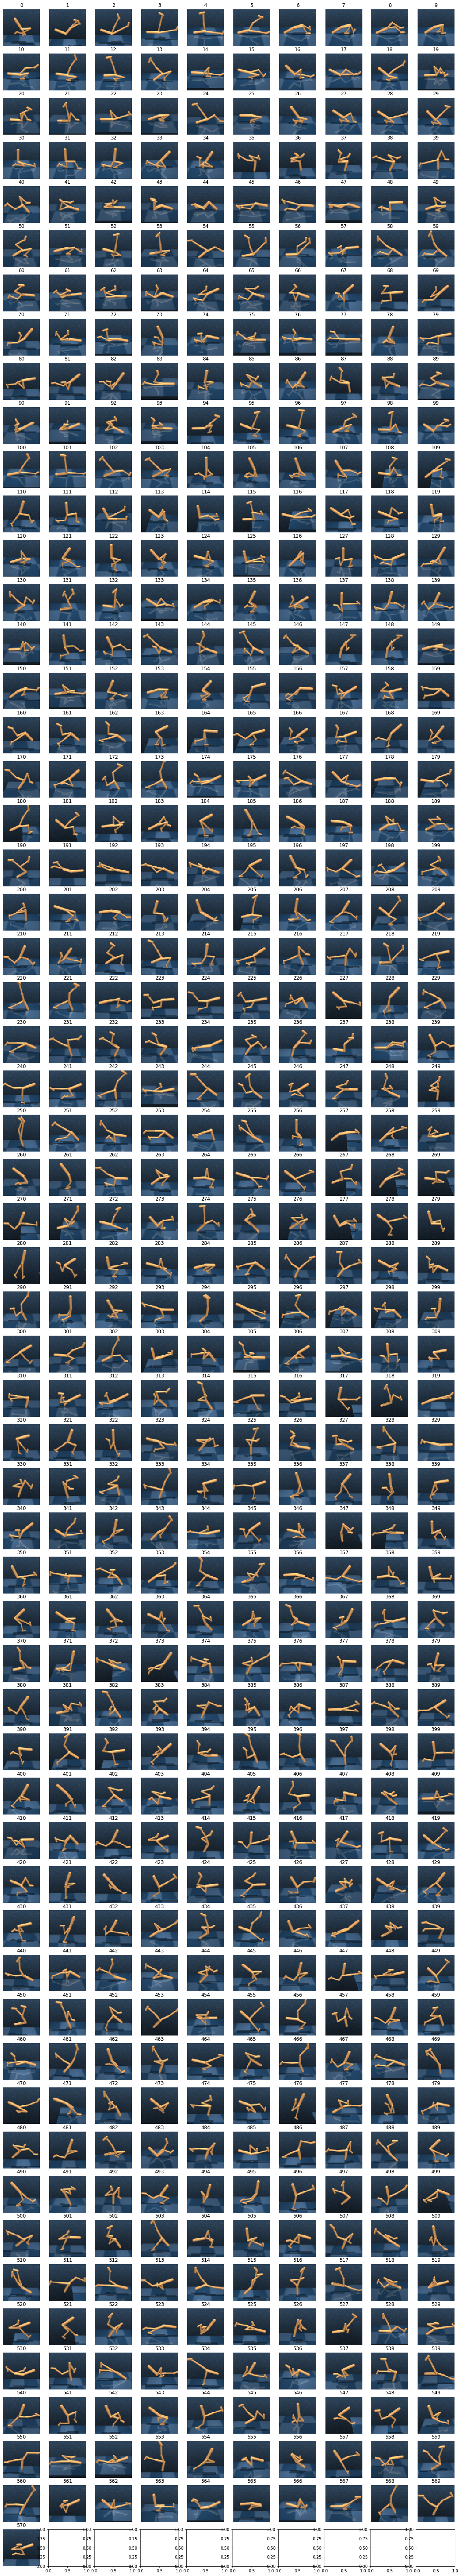

In [12]:
n = len(memory)
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))

for i in range(n):
    img = get_img_from_state(memory.states[i], env)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

In [13]:
def retrieve_path(pred, i, j):
    if pred[i, j] == -9999:
        return [i]
    path = retrieve_path(pred, i, pred[i, j])
    path.append(j)
    return path

def show_path(env, memory, i, j, state1, state2):
    path = retrieve_path(memory.pred, i, j)
    n = len(path)
    num_cols = n + 2
    num_rows = 1
    _, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))
    img = get_img_from_state(state1, env)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    
    for p in range(1, n+1):
        img = get_img_from_state(memory.states[path[p - 1]], env)
        ax[p].imshow(img.transpose((1, 2, 0)))
        ax[p].axis('off')
        ax[p].set_title(str(path[p - 1]))

    img = get_img_from_state(state2, env)
    ax[-1].imshow(img.transpose((1, 2, 0)))
    ax[-1].axis('off')

    plt.show()

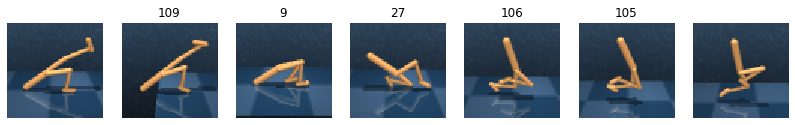

In [14]:
_, i1, j1 = expl_buffer.get_random_obs()
_, i2, j2 = expl_buffer.get_random_obs()
show_path(
    env,
    memory,
    memory.nn_out[i1, j1],
    memory.nn_in[i2, j2],
    expl_buffer.states[i1, j1],
    expl_buffer.states[i2, j2]
)

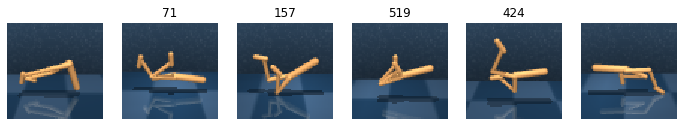

In [21]:
_, i1, j1 = expl_buffer.get_random_obs()
_, i2, j2 = expl_buffer.get_random_obs()
show_path(
    env,
    memory,
    71, 424,
    expl_buffer.states[i1, j1],
    expl_buffer.states[i2, j2]
)

tensor(43)
tensor(93)
tensor(75)
tensor(76)
tensor(72)


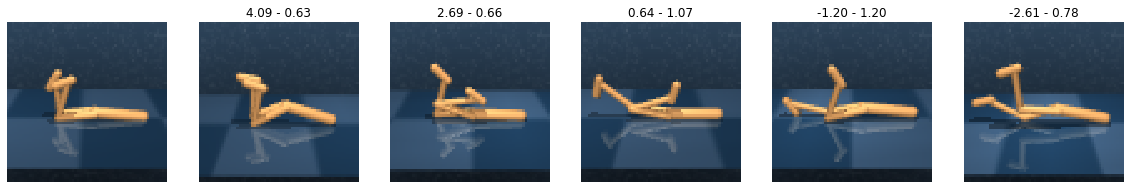

In [15]:
def show_kNN(env, model, memory, obs, state, k=9):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out = memory.compare_embeddings(e, model)
    idx =  torch.argsort(out, descending=True)
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = walker_utils.get_state_from_lexa(env, state[:9]) 
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx[i]]
        print(idx[i])
        obs = walker_utils.get_state_from_lexa(env, state_NN[:9]) 
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out[idx[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()

obs, i, j = expl_buffer.get_random_obs()
state = expl_buffer.get_state(i, j)
show_kNN(env, model, memory, obs, state, k=5)

tensor(131)
tensor(55)
tensor(115)
tensor(218)
tensor(56)


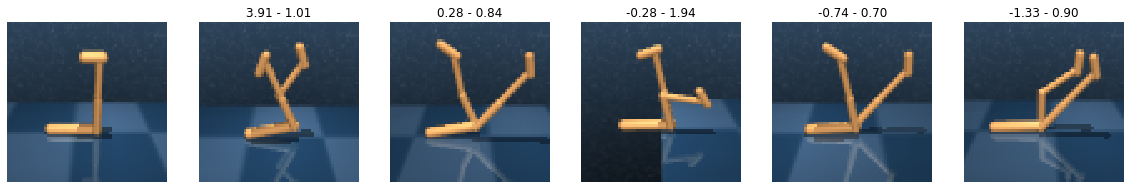

In [16]:
def get_NN(env, model, memory, obs, state):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out = memory.compare_embeddings(e, model)
    idx =  torch.argsort(out, descending=True)
    return idx[0].item()

i = np.random.randint(12)
#i=10
state = env.goals['state'][i]
obs = env.goals['vec_obs'][i]
#get_NN(env, model, memory, obs, state)
show_kNN(env, model, memory, obs, state, k=5)

In [17]:
memory.edge2rb[list(memory.edge2rb.keys())[1]]

[(0, 167),
 (0, 167),
 (0, 167),
 (34, 309),
 (34, 309),
 (34, 309),
 (34, 339),
 (34, 339),
 (34, 339),
 (34, 766),
 (34, 766),
 (34, 766),
 (34, 820),
 (34, 820),
 (34, 820),
 (34, 854),
 (34, 963),
 (34, 963),
 (34, 963),
 (47, 644),
 (47, 644),
 (47, 644),
 (47, 884),
 (47, 884),
 (47, 884),
 (47, 952),
 (47, 952),
 (47, 952),
 (47, 989),
 (47, 989),
 (47, 989),
 (148, 652),
 (148, 652),
 (2676, 89),
 (4899, 105),
 (4899, 105),
 (6902, 208)]

In [29]:
def show_edge(env, memory, k=5):
    edge = random.choice(list(memory.edge2rb.keys()))
    edge = (519, 424)
    fig, ax = plt.subplots(k + 1, 2, figsize=(4, 10))
    for i in range(2):
        img = get_img_from_state(memory.states[edge[i]], env)
        ax[0, i].imshow(img.transpose(1, 2, 0))
        ax[0, i].axis('off')
    num_samples = min(k, len(memory.edge2rb[edge]))
    assert (7011, 860) in memory.edge2rb[edge]
    transitions = random.sample(memory.edge2rb[edge], num_samples)
    for j in range(num_samples):
        for i in range(2):
            img = get_img_from_state(
                expl_buffer.get_state(transitions[j][0], transitions[j][1] + i * 1), env
            )
            ax[j + 1, i].imshow(img.transpose(1, 2, 0))
            ax[j + 1, i].axis('off')
    plt.show()

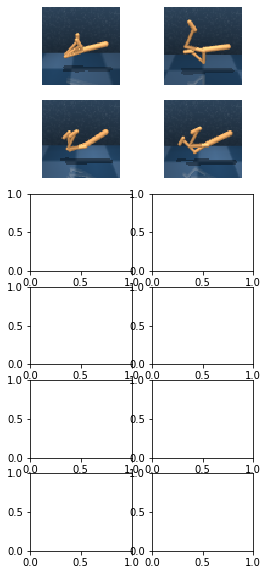

In [30]:
show_edge(env, memory)

In [32]:
memory.nn_in[7011, 861]

424